4 вариант: <br>
MSE: лин рег 60.2<br>
Пропуски в рейтинге нулями <br>
Из опыта вытащить число <br>
Предмет, курсы, категории статус среднее по категории <br>
2 и 3 образование, степень и звание в бинарный признак. <br>
Первое образвоние нормализуем, отсекаем 20 популярных, присваиваем среднее по категории <br>
Векторизуем описание, описание опыта работы, описание образования

In [ ]:
!pip install opendatasets

**Импорт библиотек и загрузка датасета**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
import ast
import re
pd.set_option('display.max_columns', None)

In [ ]:
od.download('https://www.kaggle.com/competitions/tutors-lessons-prices-prediction/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: daniillosev
Your Kaggle Key: ··········


100%|██████████| 2.56M/2.56M [00:00<00:00, 610MB/s]


Extracting archive ./tutors-lessons-prices-prediction/tutors-lessons-prices-prediction.zip to ./tutors-lessons-prices-prediction


In [ ]:
train = pd.read_excel('/content/tutors-lessons-prices-prediction/train.xlsx')
test = pd.read_excel('/content/tutors-lessons-prices-prediction/test.xlsx')

**Анализ данных**

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        4548 non-null   int64  
 1   предмет           4548 non-null   object 
 2   ФИО               4548 non-null   object 
 3   tutor_head_tags   4548 non-null   object 
 4   tutor_rating      3959 non-null   float64
 5   tutor_reviews     4548 non-null   int64  
 6   description       4547 non-null   object 
 7   experience_desc   2171 non-null   object 
 8   Education_1       4548 non-null   object 
 9   Desc_Education_1  4472 non-null   object 
 10  Education_2       781 non-null    object 
 11  Desc_Education_2  777 non-null    object 
 12  Education_3       106 non-null    object 
 13  Desc_Education_3  105 non-null    object 
 14  Education_4       16 non-null     object 
 15  Desc_Education_4  16 non-null     object 
 16  Ученая степень 1  76 non-null     object 


In [ ]:
drop_col = ['Unnamed: 0', 'ФИО', 'Desc_Education_2', 'Desc_Education_3',
            'Desc_Education_4', 'Desc_Education_5', 'Desc_Education_6',
            'Education_4', 'Education_5', 'Education_6', 'Ученая степень 2', 'Ученое звание 2']
train.drop(columns=drop_col, axis=1, inplace=True)
test.drop(columns=drop_col, axis=1, inplace=True)

Удалим ФИО, так как не несет никакого смысла для обучения <br>
Удалим ученую степень и звание 2, так как нет значений(только пробелы). <br>
Удалим Education_4-6 и Desc_Education_4-6 так как мало значений.

In [ ]:
mask = (train['tutor_rating'].isna()) & (train['tutor_reviews'] > 0)
check = train[mask]
print(check)

Empty DataFrame
Columns: [Unnamed: 0, предмет, ФИО, tutor_head_tags, tutor_rating, tutor_reviews, description, experience_desc, Education_1, Desc_Education_1, Education_2, Desc_Education_2, Education_3, Desc_Education_3, Education_4, Desc_Education_4, Ученая степень 1, Ученое звание 1, status, experience, Desc_Education_5, Desc_Education_6, Education_5, Education_6, Ученая степень 2, Ученое звание 2, categories, mean_price]
Index: []


In [ ]:
mask = (test['tutor_rating'].isna()) & (test['tutor_reviews'] > 0)
check = test[mask]
print(check)

Empty DataFrame
Columns: [Unnamed: 0, предмет, ФИО, tutor_head_tags, tutor_rating, tutor_reviews, description, experience_desc, Education_1, Desc_Education_1, Education_2, Desc_Education_2, Education_3, Desc_Education_3, Education_4, Desc_Education_4, Ученая степень 1, Ученое звание 1, status, experience, Desc_Education_5, Desc_Education_6, Education_5, Education_6, Ученая степень 2, Ученое звание 2, categories]
Index: []


In [ ]:
train['tutor_rating'] = train['tutor_rating'].fillna(0)
test['tutor_rating'] = test['tutor_rating'].fillna(0)

Пропуски в рейтинге есть только при нуле отзывов, поэтому заполним из нулями

In [ ]:
train['experience'] = train['experience'].fillna('0')
train['experience'] = train['experience'].str.split().str[0].astype(int)

test['experience'] = test['experience'].fillna('0')
test['experience'] = test['experience'].str.split().str[0].astype(int)

Из опыта берем число лет

In [ ]:
for index in range(2, 4):
    train[f'Education_{index}'] = train[f'Education_{index}'].fillna('репетитор не предоставил информацию об образовании')
    train[f'Education_{index}'] = train[f'Education_{index}'].apply(lambda x: x.lower().strip())

    mask = train[f'Education_{index}'] == 'репетитор не предоставил информацию об образовании'
    train[f'Education_{index}'] = (~mask).astype(int)

    test[f'Education_{index}'] = test[f'Education_{index}'].fillna('репетитор не предоставил информацию об образовании')
    test[f'Education_{index}'] = test[f'Education_{index}'].apply(lambda x: x.lower().strip())

    mask = test[f'Education_{index}'] == 'репетитор не предоставил информацию об образовании'
    test[f'Education_{index}'] = (~mask).astype(int)

In [ ]:
train['Ученая степень 1'] = train['Ученая степень 1'].replace(' ', np.nan)
train['Ученое звание 1'] = train['Ученое звание 1'].replace(' ', np.nan)
test['Ученая степень 1'] = test['Ученая степень 1'].replace(' ', np.nan)
test['Ученое звание 1'] = test['Ученое звание 1'].replace(' ', np.nan)

train.loc[train['Ученое звание 1'].notna(), 'Ученое звание 1'] = 1
train.loc[train['Ученая степень 1'].notna(), 'Ученая степень 1'] = 1
test.loc[test['Ученое звание 1'].notna(), 'Ученое звание 1'] = 1
test.loc[test['Ученая степень 1'].notna(), 'Ученая степень 1'] = 1

train['Ученое звание 1'] = train['Ученое звание 1'].fillna(0)
train['Ученая степень 1'] = train['Ученая степень 1'].fillna(0)
test['Ученое звание 1'] = test['Ученое звание 1'].fillna(0)
test['Ученая степень 1'] = test['Ученая степень 1'].fillna(0)

<ipython-input-294-50a2951158ec>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['Ученое звание 1'] = train['Ученое звание 1'].fillna(0)
<ipython-input-294-50a2951158ec>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['Ученая степень 1'] = train['Ученая степень 1'].fillna(0)
<ipython-input-294-50a2951158ec>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('futur

Переводим второе и третье образование в бинарный признак(есть\нет). То же самое повторяем с званием и степенью

In [ ]:
train['tutor_head_tags'] = train['tutor_head_tags'].apply(ast.literal_eval)
test['tutor_head_tags'] = test['tutor_head_tags'].apply(ast.literal_eval)

tags_df = train[['tutor_head_tags', 'mean_price']].explode('tutor_head_tags')

tag_mean_price = tags_df.groupby('tutor_head_tags')['mean_price'].mean()

tag_price_dict = tag_mean_price.to_dict()

global_mean_price = train['mean_price'].mean()

def compute_tag_price(tags):
    prices = [tag_price_dict.get(tag) for tag in tags if tag in tag_price_dict]
    if prices:
        return np.mean(prices)
    else:
        return global_mean_price

train['tutor_head_tags'] = train['tutor_head_tags'].apply(compute_tag_price)
test['tutor_head_tags'] = test['tutor_head_tags'].apply(compute_tag_price)


In [ ]:
train['categories'] = train['categories'].apply(ast.literal_eval)
test['categories'] = test['categories'].apply(ast.literal_eval)

tags_df = train[['categories', 'mean_price']].explode('categories')

tag_mean_price = tags_df.groupby('categories')['mean_price'].mean()

tag_price_dict = tag_mean_price.to_dict()

def compute_tag_price(tags):
    prices = [tag_price_dict.get(tag) for tag in tags if tag in tag_price_dict]
    return np.mean(prices) if prices else np.nan

train['categories'] = train['categories'].apply(compute_tag_price)
test['categories'] = test['categories'].apply(compute_tag_price)

In [ ]:
train['status'] = train['status'].fillna('нет')
test['status'] = test['status'].fillna('нет')

train['status'] = train['status'].str.lower()
train['status'] = train['status'].str.split(',')
test['status'] = test['status'].str.lower()
test['status'] = test['status'].str.split(',')

tags_df = train[['status', 'mean_price']].explode('status')

tag_mean_price = tags_df.groupby('status')['mean_price'].mean()

tag_price_dict = tag_mean_price.to_dict()

def compute_tag_price(tags):
    prices = [tag_price_dict.get(tag) for tag in tags if tag in tag_price_dict]
    return np.mean(prices) if prices else np.nan

train['status'] = train['status'].apply(compute_tag_price)
test['status'] = test['status'].apply(compute_tag_price)

In [ ]:
train['предмет'] = train['предмет'].str.strip().str.lower()
test['предмет'] = test['предмет'].str.strip().str.lower()

subject_mean_price = train.groupby('предмет')['mean_price'].mean()
subject_price_dict = subject_mean_price.to_dict()

train['предмет'] = train['предмет'].map(subject_price_dict)
test['предмет'] = test['предмет'].map(subject_price_dict)

default_price = train['mean_price'].mean()
test['предмет'] = test['предмет'].fillna(default_price)

Категориальные переменные кодируем срденим значениме целевой переменной по категории

In [ ]:
def clean_education_name(text):
    if pd.isna(text):
        return "unknown"
    text = text.lower()
    text = re.sub(r'[^а-яёa-z]', '', text)
    return text

train['Education_1'] = train['Education_1'].apply(clean_education_name)
train['Education_1'] = train['Education_1'].replace('репетиторнепредоставилинформациюобобразовании', 'unknown')
test['Education_1'] = test['Education_1'].apply(clean_education_name)
test['Education_1'] = test['Education_1'].replace('репетиторнепредоставилинформациюобобразовании', 'unknown')

Чтобы уменьшить количесвто разных написаний одного университета, приводим строки к нижнему регистру и оставляем только буквы

In [ ]:
top_n_edu1 = train['Education_1'].value_counts().nlargest(20).index
train['Education_1'] = train['Education_1'].where(train['Education_1'].isin(top_n_edu1), 'other')

top_n_edu1 = test['Education_1'].value_counts().nlargest(20).index
test['Education_1'] = test['Education_1'].where(test['Education_1'].isin(top_n_edu1), 'other')

In [ ]:
subject_mean_price = train.groupby('Education_1')['mean_price'].mean()
subject_price_dict = subject_mean_price.to_dict()

train['Education_1'] = train['Education_1'].map(subject_price_dict)
test['Education_1'] = test['Education_1'].map(subject_price_dict)

default_price = train['mean_price'].mean()
test['Education_1'] = test['Education_1'].fillna(default_price)

Берем 20 популярнейших вузов, остальные кодируем в other. Потом берем среднее по категории

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   предмет           4548 non-null   float64
 1   tutor_head_tags   4548 non-null   float64
 2   tutor_rating      4548 non-null   float64
 3   tutor_reviews     4548 non-null   int64  
 4   description       4547 non-null   object 
 5   experience_desc   2171 non-null   object 
 6   Education_1       4548 non-null   float64
 7   Desc_Education_1  4472 non-null   object 
 8   Education_2       4548 non-null   int64  
 9   Education_3       4548 non-null   int64  
 10  Ученая степень 1  4548 non-null   int64  
 11  Ученое звание 1   4548 non-null   int64  
 12  status            4548 non-null   float64
 13  experience        4548 non-null   int64  
 14  categories        4548 non-null   float64
 15  mean_price        4548 non-null   float64
dtypes: float64(7), int64(6), object(3)
memory 

In [ ]:
train['description'] = train['description'].fillna('репетитор не предоставил о себе дополнительных сведений')
train['description'] = train['description'].apply(lambda x: x.lower().strip())

test['description'] = test['description'].fillna('репетитор не предоставил о себе дополнительных сведений')
test['description'] = test['description'].apply(lambda x: x.lower().strip())

vectorizer = TfidfVectorizer(max_features=100)
X_text = vectorizer.fit_transform(train['description'])

tfidf_df_train = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out(), index=train.index)
train.drop(columns=['description'], inplace=True)
train = pd.concat([train, tfidf_df_train], axis=1)

X_text = vectorizer.transform(test['description'])
tfidf_df_test = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out(), index=test.index)
test.drop(columns=['description'], inplace=True)
test = pd.concat([test, tfidf_df_test], axis=1)

In [ ]:
train['experience_desc'] = train['experience_desc'].fillna('репетитор не предоставил информацию об опыте работы')
train['experience_desc'] = train['experience_desc'].apply(lambda x: x.lower().strip())

test['experience_desc'] = test['experience_desc'].fillna('репетитор не предоставил информацию об опыте работы')
test['experience_desc'] = test['experience_desc'].apply(lambda x: x.lower().strip())

vectorizer = TfidfVectorizer(max_features=100)
X_text = vectorizer.fit_transform(train['experience_desc'])

tfidf_df_train = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out(), index=train.index)
train.drop(columns=['experience_desc'], inplace=True)
train = pd.concat([train, tfidf_df_train], axis=1)

X_text = vectorizer.transform(test['experience_desc'])
tfidf_df_test = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out(), index=test.index)
test.drop(columns=['experience_desc'], inplace=True)
test = pd.concat([test, tfidf_df_test], axis=1)

In [ ]:
for i in range(1, 2):
  train[f'Desc_Education_{i}'] = train[f'Desc_Education_{i}'].fillna('нет описания')
  train[f'Desc_Education_{i}'] = train[f'Desc_Education_{i}'].apply(lambda x: x.lower().strip())

  test[f'Desc_Education_{i}'] = test[f'Desc_Education_{i}'].fillna('нет описания')
  test[f'Desc_Education_{i}'] = test[f'Desc_Education_{i}'].apply(lambda x: x.lower().strip())

  vectorizer = TfidfVectorizer(max_features=50)
  X_text = vectorizer.fit_transform(train[f'Desc_Education_{i}'])

  tfidf_df_train = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out(), index=train.index)
  train.drop(columns=[f'Desc_Education_{i}'], inplace=True)
  train = pd.concat([train, tfidf_df_train], axis=1)

  X_text = vectorizer.transform(test[f'Desc_Education_{i}'])
  tfidf_df_test = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out(), index=test.index)
  test.drop(columns=[f'Desc_Education_{i}'], inplace=True)
  test = pd.concat([test, tfidf_df_test], axis=1)

Векторизуем описание, описание опыта работы и описание образования

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Columns: 263 entries, предмет to экономика
dtypes: float64(257), int64(6)
memory usage: 9.1 MB


**Машинное обучение**

In [ ]:
X = train.drop(['mean_price'], axis=1)
Y = train['mean_price']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

Для проверки стратегии

In [ ]:
x_train = train.drop(['mean_price'], axis=1)
y_train = train['mean_price']
x_test = test

Для финального ответа

In [ ]:
std = StandardScaler()
x_train_scaled = std.fit_transform(x_train)
x_test_scaled = std.transform(x_test)

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(x_train_scaled, y_train)
y_pred = lin_reg.predict(x_test_scaled)

In [ ]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R2 score:', r2_score(y_test, y_pred))

Mean Absolute Error: 6.666593086945306
Mean Squared Error: 95.428619872298
R2 score: 0.1639138794653825


In [ ]:
scores = []

for i in range(3, 31):
    score = {}
    knn = KNeighborsRegressor(i)
    knn.fit(x_train_scaled, y_train)
    answers = knn.predict(x_test_scaled)

    score['k'] = i
    score['MSE'] = mean_squared_error(y_test, answers)
    score['r2'] = r2_score(y_test, answers)
    scores.append(score)

scores = pd.DataFrame(scores)
scores

,k,MSE,r2
0,3,121.227964,-0.062124
1,4,116.351482,-0.019399
2,5,114.290284,-0.001340
3,6,113.224028,0.008002
4,7,112.475452,0.014560
5,8,111.417403,0.023830
6,9,110.473274,0.032102
7,10,110.329821,0.033359
8,11,109.706514,0.038820
9,12,110.189655,0.034587


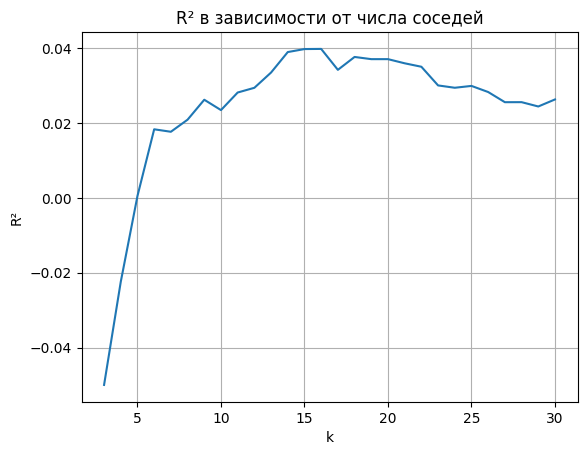

In [ ]:
plt.plot(scores['k'], scores['r2'])
plt.xlabel('k')
plt.ylabel('R²')
plt.title('R² в зависимости от числа соседей')
plt.grid(True)
plt.show()

In [ ]:
knn = KNeighborsRegressor(25)
knn.fit(x_train_scaled, y_train)
y_pred = knn.predict(x_test_scaled)

**Формирование ответа**

In [ ]:
d = {'mean_price' : y_pred}
res = pd.DataFrame(d)
res.index.name = 'index'
res.to_csv('output.csv')